# import the needed Imports 

In [1]:
from tqdm import tqdm
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader,random_split
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import random
import pandas as pd



# load Efficient model to fine_tuning

In [2]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

# Preprocessing Images for EfficientNet Model

As the images in the dataset have different sizes, preprocessing is necessary to ensure that all images are of uniform size suitable for input into the EfficientNet model, which requires images of size 224x224x3.

The following steps outline the preprocessing procedure:

1. **Padding:** Add padding to the images to ensure that each image has a consistent aspect ratio. Padding can be added uniformly to the sides of the image to make it square.

2. **Resize:** After padding, resize the images to the desired dimensions of 224x224 pixels while maintaining the aspect ratio. Resizing will ensure that all images have the same dimensions required by the EfficientNet model.

3. **To_Tensor and Normalize:** After resizing and padding, the images are converted into PyTorch tensors. This step is essential as PyTorch tensors .Finally, the pixel values of the images are normalized using the mean and standard deviation values provided. Normalization helps to standardize the pixel values across all images, making the training process more stable and efficient.



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def resize_and_pad(img, size, padding_mode='constant'):
    # Calculate padding
    w, h = img.size
    longest_edge = max(w, h)
    horizontal_padding = (longest_edge - w) / 2
    vertical_padding = (longest_edge - h) / 2
    padding = (int(horizontal_padding), int(vertical_padding), 
               int(horizontal_padding), int(vertical_padding))
    # Pad and resize
    img = transforms.functional.pad(img, padding, padding_mode=padding_mode)
    img = transforms.functional.resize(img, size)
    return img

transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_and_pad(img, (224, 224), 'constant')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='/kaggle/input/slash-dataset/slash data', transform=transform)

# Dataset Analysis Results

After conducting an analysis on the dataset, the following observations were made:

## Imbalanced Data Issue
The dataset exhibits a significant class imbalance problem. The distribution of classes in the dataset is as follows:

Accessories: 10.81%
Beauty: 6.12%
Fashion: 46.74%
Games: 4.69%
Home: 14.58%
Nutrition: 3.78%
Stationary: 13.28%

## Action Required
To address the imbalanced data issue, appropriate techniques such as oversampling

In [4]:
# Get the class names
class_names = dataset.classes

# Get the number of classes
num_classes = len(class_names)

# Get the total number of images in the dataset
total_images = len(dataset)

# Count the number of images per class
class_counts = {class_name: 0 for class_name in class_names}
for _, label in dataset:
    class_counts[class_names[label]] += 1

# Calculate class distribution
class_distribution = {class_name: count / total_images for class_name, count in class_counts.items()}

# Print statistics
print(f"Number of classes: {num_classes}")
print(f"Total number of images: {total_images}")
print("Number of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")
print("Class distribution:")
for class_name, distribution in class_distribution.items():
    print(f"{class_name}: {distribution:.2%}")

Number of classes: 7
Total number of images: 768
Number of images per class:
Accessories: 83
Beauty: 47
Fashion: 359
Games: 36
Home: 112
Nutrition: 29
Stationary: 102
Class distribution:
Accessories: 10.81%
Beauty: 6.12%
Fashion: 46.74%
Games: 4.69%
Home: 14.58%
Nutrition: 3.78%
Stationary: 13.28%


# Split data into training, validation, and test sets datasets

In [5]:
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  #15% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



# Showing the Distribution of Classes in Train Dataset

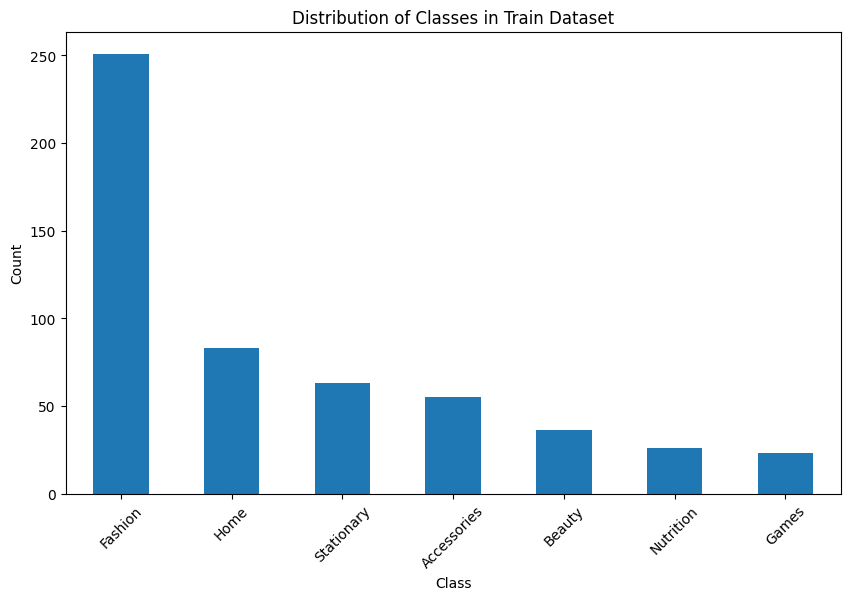

In [6]:

# Extract labels from train_dataset
train_labels = [label for _, label in train_dataset]

# Convert train_labels to class names

class_names = ['Accessories','Beauty','Fashion', 'Games', 'Home', 'Nutrition','Stationary']  

# Convert numerical labels to class names
train_labels_names = [class_names[label] for label in train_labels]

# Convert train_labels to a pandas DataFrame for easier manipulation
train_labels_df = pd.DataFrame(train_labels_names, columns=['label'])

# Count occurrences of each class label
class_distribution = train_labels_df['label'].value_counts()

# Plotting the distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Classes in Train Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Solving the Imbalanced Dataset Problem in the Training Dataset Using Oversampling

#### To address the issue of imbalanced classes in the training dataset, an oversampling approach is employed. Oversampling involves increasing the number of instances in the minority class(es) to balance the dataset.



In [7]:

data_shape = (3,224, 224)
# Extract features and labels from train_dataset
train_data = np.array([data.numpy().flatten() for data, label in train_dataset])  # Flatten the images
train_labels = np.array([label for data, label in train_dataset])

# Check class distribution before oversampling
print("Class distribution before oversampling:", Counter(train_labels))

# Calculate the size of the majority class
majority_class_size = Counter(train_labels).most_common(1)[0][1]

# Initialize the RandomOverSampler with sampling_strategy
oversampler = RandomOverSampler(sampling_strategy={label: majority_class_size for label in np.unique(train_labels)}, random_state=42)

# Perform oversampling
train_data_resampled_flat, train_labels_resampled = oversampler.fit_resample(train_data, train_labels)

# Reshape the flattened images back to their original shape
train_data_resampled = np.array([image.reshape(data_shape) for image in train_data_resampled_flat])  

# Check class distribution after oversampling
print("Class distribution after oversampling:", Counter(train_labels_resampled))



Class distribution before oversampling: Counter({2: 251, 4: 83, 6: 63, 0: 55, 1: 36, 5: 26, 3: 23})
Class distribution after oversampling: Counter({2: 251, 6: 251, 4: 251, 0: 251, 3: 251, 5: 251, 1: 251})


# Showing a Sample from the train_dataset images

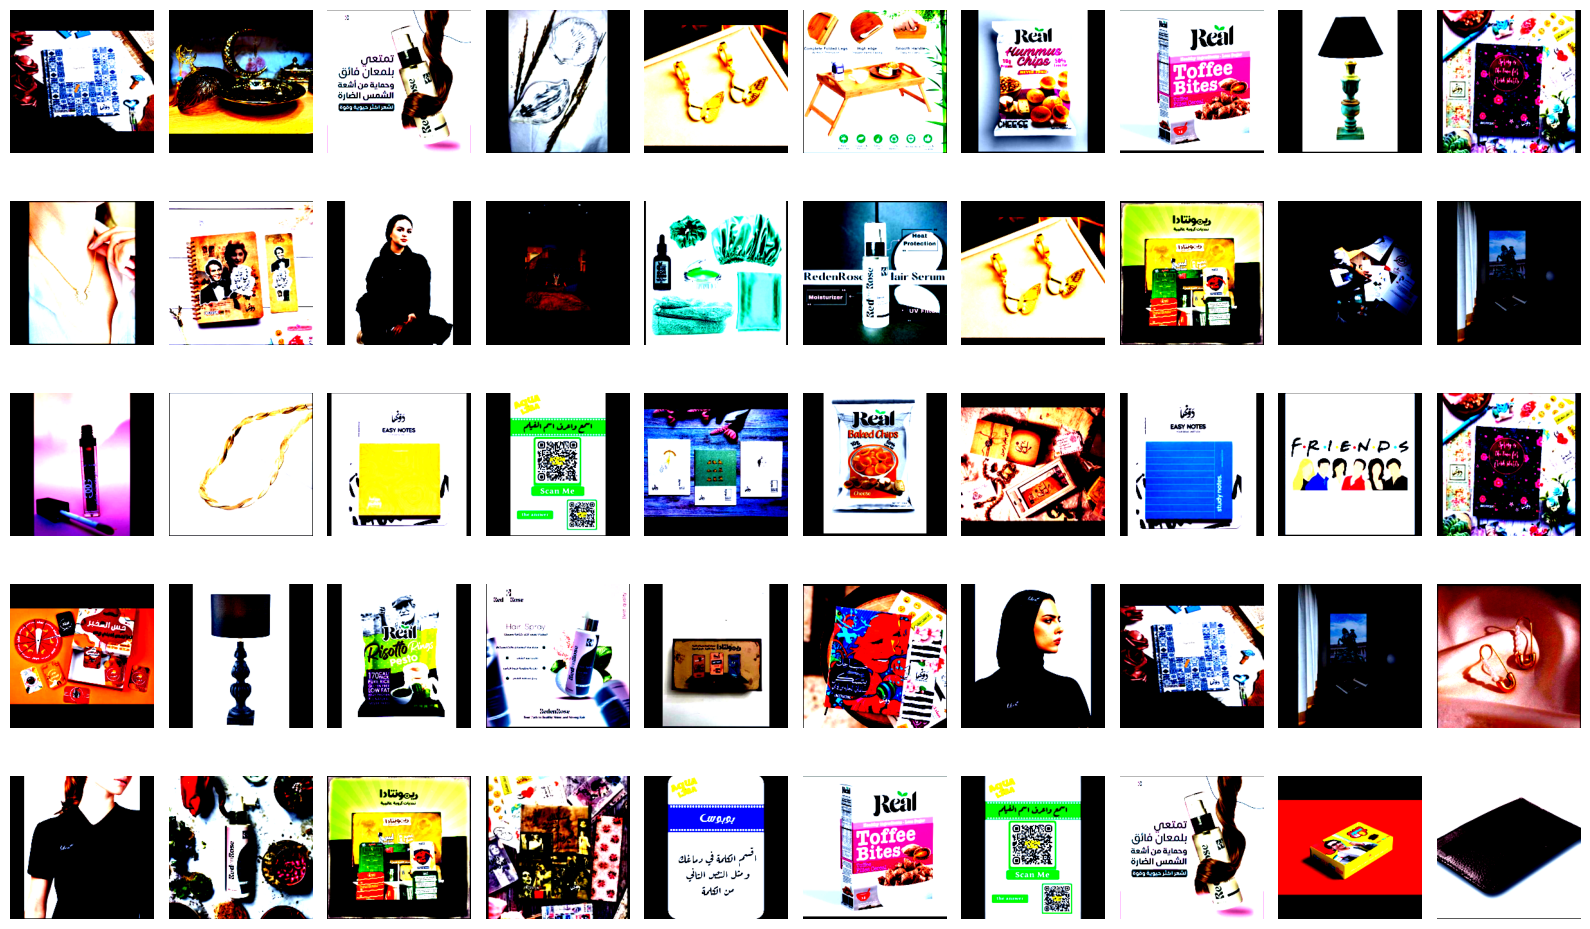

In [8]:
num_images = 50

# Convert oversampled data to PyTorch tensors
train_data_resampled_tensor = torch.tensor(train_data_resampled)
train_labels_resampled_tensor = torch.tensor(train_labels_resampled)

# Get the total number of images in the dataset
total_images = len(train_data_resampled_tensor)

# Create a figure and axis object
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(16, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Randomly select indices of images to plot
indices = random.sample(range(total_images), num_images)

# Plot each image
for i, idx in enumerate(indices):
    image = train_data_resampled_tensor[idx].numpy().transpose((1, 2, 0))  # Assuming images are in (C, H, W) format
    axes[i].imshow(image)
    axes[i].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Using DataLoader to Load train_loader ,valid_loader ,test_loader :

In [9]:

# Create a TensorDataset from the oversampled data
oversampled_dataset = TensorDataset(train_data_resampled_tensor, train_labels_resampled_tensor)

# Define DataLoader for the oversampled dataset
train_loader = DataLoader(oversampled_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Modified EfficientNet Model Architecture

The `ModifiedEfficientNet` class is a neural network model designed for multi-class classification tasks. It is based on the EfficientNet architecture with custom modifications.

#### Model Components:
- Convolutional Layers
- Transpose Convolutional Layer
- Base EfficientNet Model

#### Instantiating the Model:
- An instance of the `ModifiedEfficientNet` class is created with the specified number of output classes (`7`).
- The model parameters are optimized using the Adam optimizer with a learning rate of `0.001`.
- The loss function used for optimization is the Cross Entropy Loss.


In [10]:
class ModifiedEfficientNet(nn.Module):
    def __init__(self, n_classes):
        super(ModifiedEfficientNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.base_model = EfficientNet.from_pretrained('efficientnet-b2')
        num_ftrs = self.base_model._fc.in_features
        self.base_model._fc = nn.Linear(num_ftrs, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x= self.trans_conv1(x)
        x = self.base_model(x)
        return x

model = ModifiedEfficientNet(7)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Loaded pretrained weights for efficientnet-b2


# The Train loop :

In [11]:

num_epochs = 20
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    for name, param in model.named_parameters():
            if (name.endswith('weight')):
                            param.requires_grad = True
            else:
                param.requires_grad = False

    for batch_inputs,batch_targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        batch_inputs,batch_targets = batch_inputs.to('cuda'),batch_targets.to('cuda')
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        optimizer.zero_grad()
        loss.backward()

        epoch_loss += loss.item()

        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {epoch_loss/len(train_loader):.4f}')

    # Validation phase
    model.eval()
    with torch.no_grad():
        for batch_inputs, batch_targets in tqdm(valid_loader, desc=f'validating Epoch {epoch+1}/{num_epochs}'):
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            # Forward pass
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 1)
            total += batch_targets.size(0)
            correct += (predicted == batch_targets).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {epoch_loss/len(train_loader):.4f}, Validation Accuracy: {accuracy:.2f}%')

Epoch 1/20: 100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


Epoch [1/20], Average Train Loss: 0.5234


validating Epoch 1/20: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


Epoch [1/20], Average Train Loss: 0.5234, Validation Accuracy: 34.78%


Epoch 2/20: 100%|██████████| 55/55 [00:17<00:00,  3.15it/s]


Epoch [2/20], Average Train Loss: 0.1034


validating Epoch 2/20: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch [2/20], Average Train Loss: 0.1034, Validation Accuracy: 51.30%


Epoch 3/20: 100%|██████████| 55/55 [00:17<00:00,  3.11it/s]


Epoch [3/20], Average Train Loss: 0.0794


validating Epoch 3/20: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch [3/20], Average Train Loss: 0.0794, Validation Accuracy: 59.13%


Epoch 4/20: 100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


Epoch [4/20], Average Train Loss: 0.1135


validating Epoch 4/20: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Epoch [4/20], Average Train Loss: 0.1135, Validation Accuracy: 72.17%


Epoch 5/20: 100%|██████████| 55/55 [00:18<00:00,  3.04it/s]


Epoch [5/20], Average Train Loss: 0.0687


validating Epoch 5/20: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Epoch [5/20], Average Train Loss: 0.0687, Validation Accuracy: 60.87%


Epoch 6/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


Epoch [6/20], Average Train Loss: 0.0574


validating Epoch 6/20: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch [6/20], Average Train Loss: 0.0574, Validation Accuracy: 82.61%


Epoch 7/20: 100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


Epoch [7/20], Average Train Loss: 0.0098


validating Epoch 7/20: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


Epoch [7/20], Average Train Loss: 0.0098, Validation Accuracy: 78.26%


Epoch 8/20: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


Epoch [8/20], Average Train Loss: 0.0245


validating Epoch 8/20: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Epoch [8/20], Average Train Loss: 0.0245, Validation Accuracy: 73.91%


Epoch 9/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


Epoch [9/20], Average Train Loss: 0.0717


validating Epoch 9/20: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Epoch [9/20], Average Train Loss: 0.0717, Validation Accuracy: 76.52%


Epoch 10/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


Epoch [10/20], Average Train Loss: 0.1200


validating Epoch 10/20: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch [10/20], Average Train Loss: 0.1200, Validation Accuracy: 66.09%


Epoch 11/20: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


Epoch [11/20], Average Train Loss: 0.0708


validating Epoch 11/20: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Epoch [11/20], Average Train Loss: 0.0708, Validation Accuracy: 71.30%


Epoch 12/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


Epoch [12/20], Average Train Loss: 0.0191


validating Epoch 12/20: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Epoch [12/20], Average Train Loss: 0.0191, Validation Accuracy: 80.87%


Epoch 13/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


Epoch [13/20], Average Train Loss: 0.0132


validating Epoch 13/20: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


Epoch [13/20], Average Train Loss: 0.0132, Validation Accuracy: 84.35%


Epoch 14/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


Epoch [14/20], Average Train Loss: 0.0199


Epoch 17/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]1.25it/s]


Epoch [17/20], Average Train Loss: 0.0157


validating Epoch 17/20: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch [17/20], Average Train Loss: 0.0157, Validation Accuracy: 73.91%


Epoch 18/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


Epoch [18/20], Average Train Loss: 0.0088


validating Epoch 18/20: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch [18/20], Average Train Loss: 0.0088, Validation Accuracy: 81.74%


Epoch 19/20: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


Epoch [19/20], Average Train Loss: 0.0122


validating Epoch 19/20: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


Epoch [19/20], Average Train Loss: 0.0122, Validation Accuracy: 85.22%


Epoch 20/20: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


Epoch [20/20], Average Train Loss: 0.0047


validating Epoch 20/20: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

Epoch [20/20], Average Train Loss: 0.0047, Validation Accuracy: 85.22%


# Testing the model with testing dataset

In [12]:
correct = 0
total = 0
with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) 
            labels = labels.to(device)  
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy of the network on the test images: {:.2f}%'.format(accuracy))

Accuracy of the network on the test images: 87.93%
